# Data cleaning

In [1]:
import os
import datetime
import string
import random

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='darkgrid', font_scale=1.2)

## Data loading and inspecting

In [2]:
DATA_DIR = 'data'
RAW_FILE = 'raw_data_cro.xlsx' 
RAW_DATA_PATH = os.path.join(os.pardir, DATA_DIR, RAW_FILE)

In [3]:
df = pd.read_excel(RAW_DATA_PATH)

In [4]:
df.shape

(200226, 38)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200226 entries, 0 to 200225
Data columns (total 38 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   ID_osoba                               200226 non-null  object 
 1   Datum_testiranja                       200226 non-null  object 
 2   Rezultat                               199782 non-null  float64
 3   Lokacija                               200226 non-null  object 
 4   Ustanova_koja_je_napravila_testiranja  200226 non-null  object 
 5   Hospitalizacija                        200226 non-null  int64  
 6   Respirator                             200226 non-null  int64  
 7   preminuli                              200226 non-null  int64  
 8   dob                                    200226 non-null  object 
 9   spol                                   200226 non-null  object 
 10  županija                               200226 non-null  

In [6]:
# check for NaNs
df.isnull().any()

ID_osoba                                 False
Datum_testiranja                         False
Rezultat                                  True
Lokacija                                 False
Ustanova_koja_je_napravila_testiranja    False
Hospitalizacija                          False
Respirator                               False
preminuli                                False
dob                                      False
spol                                     False
županija                                 False
I                                        False
sumcomorbidity                           False
A                                        False
B                                        False
C                                        False
D                                        False
E                                        False
F                                        False
G                                        False
H                                        False
J            

In [7]:
# only test results seem to be an issue,
# lets see how many NaNs are there
df['Rezultat'].isnull().sum()

444

## Creating a working dataset

In [8]:
# list all comorbidities A-Z
comorbidity_list = list(string.ascii_uppercase)

# drop existing sumcomorbidity column, create new and drop comorbidites
df_tidy = df.copy(deep=True)
df_tidy.drop(columns='sumcomorbidity', inplace=True)
df_tidy['sum_comorbidity'] = df_tidy[comorbidity_list].sum(axis=1)
df_tidy.drop(columns=comorbidity_list, inplace=True)
df_tidy

,ID_osoba,Datum_testiranja,Rezultat,Lokacija,Ustanova_koja_je_napravila_testiranja,Hospitalizacija,Respirator,preminuli,dob,spol,županija,sum_comorbidity
0,000D955C52,2020-07-04,0.0,RIJEKA,MEDICINSKI FAKULTET RIJEKA,0,0,0,50,1,PRIMORSKO-GORANSKA,7
1,000FE7B77A,2020-08-19,0.0,POŽEGA,O.B.POŽEGA,0,0,0,83,1,POŽEŠKO-SLAVONSKA,12
2,0022233DC0,2020-08-17,0.0,OSIJEK,ZJZ OSJEČKO-BARANJSKE ŽUPANIJE,0,0,0,42,1,OSJEČKO-BARANJSKA,9
3,0026A3B8BB,2020-06-02,0.0,KARLOVAC,KL.ZA INFEKTIVNE BOLESTI,0,0,0,89,2,KARLOVAČKA,7
4,00317D99E3,2020-06-30,0.0,OSIJEK,K.B.C.OSIJEK,0,0,0,17,2,OSJEČKO-BARANJSKA,6
...,...,...,...,...,...,...,...,...,...,...,...,...
200221,FFB0780383,2020-08-29,0.0,ZAGREB,ZJZ REPUBLIKE HRVATSKE,0,0,0,52,1,ŽUPANIJA GRAD ZAGREB,3
200222,FFB6289722,2020-08-20,0.0,VUKOVAR,K.B.C.OSIJEK,0,0,0,29,2,ŽUPANIJA VUKOVARSKO-SRIJEMSKA,7
200223,FFD598C2D0,2020-07-14,0.0,ZADAR,ZJZ ZDRAVSTVO ZADAR,0,0,0,24,1,ŽUPANIJA ZADARSKA,1
200224,FFDE31DCA8,2020-08-27,0.0,PULA,ZJZ ISTARSKE ŽUPANIJE,0,0,0,54,(null),(null),0


In [9]:
# replace '(null)' with np.Nan
df_tidy = df_tidy.replace('(null)', np.NaN)
df_tidy = df_tidy.replace('""(null)""', np.NaN)
# check for NaNs
df_tidy.isnull().sum()

ID_osoba                                     0
Datum_testiranja                             0
Rezultat                                   444
Lokacija                                     0
Ustanova_koja_je_napravila_testiranja        0
Hospitalizacija                              0
Respirator                                   0
preminuli                                    0
dob                                        134
spol                                      9774
županija                                 16451
sum_comorbidity                              0
dtype: int64

In [10]:
# convert testing date to datetime.datetime format and drop all testst before 2020-2-25
df_tidy.Datum_testiranja = df_tidy.Datum_testiranja.apply(pd.to_datetime)
df_tidy.drop(df_tidy[df_tidy.Datum_testiranja < datetime.datetime(2020, 2, 25)].index, inplace=True)

# convert testing result to bool
df_tidy.Rezultat = df_tidy.Rezultat.replace({1.0: True, 0.0: False})
df_tidy.drop(df_tidy[df_tidy.Rezultat.isnull()].index, inplace=True)

# convert hospitalization data to bool
df_tidy.Hospitalizacija = df_tidy.Hospitalizacija.replace({1: True, 0: False})

# convert respirator indicator data to bool
df_tidy.Respirator = df_tidy.Respirator.replace({1: True, 0: False})

# convert deceased data to bool
df_tidy.preminuli = df_tidy.Respirator.replace({1: True, 0: False})

# convert age to numeric and remove invalid values
df_tidy.dob = df_tidy.dob.apply(pd.to_numeric)
df_tidy.loc[df_tidy.dob < 0, 'dob'] = np.NaN
df_tidy.loc[df_tidy.dob > 105, 'dob'] = np.NaN

# convert sex to string
df_tidy.spol = df_tidy.spol.replace({1.: 'M', 2.: 'F'})

# tidy up counties
df_tidy.županija = df_tidy.županija.str.replace('ŽUPANIJA', '').str.replace(' ', '')

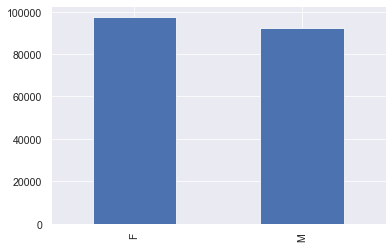

In [11]:
df_tidy.spol.value_counts().plot(kind='bar')
plt.show()

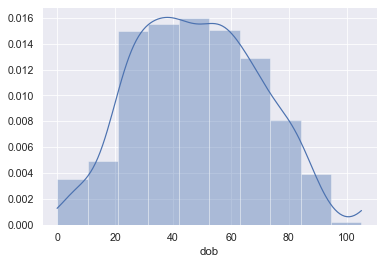

In [12]:
ax = sns.distplot(df_tidy.dob, bins=10, kde_kws=dict(bw=5, cut=0))
plt.show()

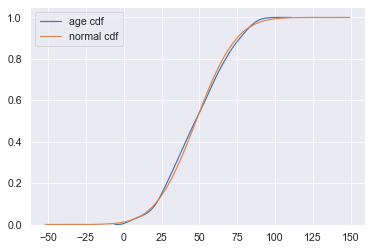

In [13]:
# lets quickly visually check if this could be described as Gaussian PDF
# for the later random generation of missing values (NaNs)
_ = sns.kdeplot(df_tidy.dob.values, cumulative=True, label='age cdf')
mu = df_tidy.dob.mean()
sigma = df_tidy.dob.std()
gaussian_cdf = np.random.normal(mu, sigma, size=df_tidy.dob.values.size)
_ = sns.kdeplot(gaussian_cdf, cumulative=True, label='normal cdf')
plt.legend(loc='upper left')
plt.show()

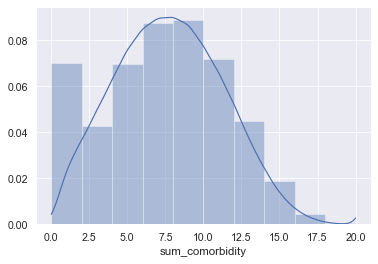

In [14]:
sns.distplot(df_tidy.sum_comorbidity, bins=10, kde_kws=dict(bw=0.6, cut=0))
plt.show()

In [16]:
# handling missing (NaN) values for sex
@np.vectorize
def gen_random_sex(x):
    return random.choice(('M', 'F')) # https://en.wikipedia.org/wiki/Fisher%27s_principle :)
df_tidy.spol[df_tidy.spol.isnull()] = df_tidy.spol.loc[df_tidy.spol.isnull()].apply(gen_random_sex)

# missing values will be filled with random values from existing age distribution because all 
# individuals with missing age are tested Negative so it is not of the greatest importance
# it could be chechked with: df_w[df_w.age.isnull() & df_w.testing_result==False]
@np.vectorize
def gen_random_age(x):
    random_nmb = -1
    while random_nmb not in range(0, 105):
        random_nmb = int(random.gauss(mu=df_tidy.dob.mean(), sigma=df_tidy.dob.std()))
    return random_nmb
df_tidy.dob[df_tidy.dob.isnull()] = df_tidy.dob.loc[df_tidy.dob.isnull()].apply(gen_random_age)

/home/alk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/alk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [17]:
# assemble clean working dataframe
# translate column names and explicitly state data type
columns_dtypes_dict = {
    'id': str, 
    'age': float, 
    'sex': str, 
    'location': str, 
    'county': str,
    'testing_date': datetime.datetime, 
    'testing_result': bool, 
    'testing_institute': str,
    'hospitalization': bool, 
    'respirator': bool, 
    'deceased': bool,
    'total_comorbidities': int,
}

# create empty dataframe with predifined data types
columns_dtypes_list = [(k, v) for k, v in columns_dtypes_dict.items()]
dtypes = np.dtype(columns_dtypes_list)
empty_matrix = np.empty(0, dtype=dtypes)
df_w = pd.DataFrame(empty_matrix)

# fill the working dataframe with clean data
df_w.id = df_tidy.ID_osoba
df_w.age = df_tidy.dob
df_w.sex = df_tidy.spol
df_w.location = df_tidy.Lokacija
df_w.county = df_tidy.županija
df_w.testing_date = df_tidy.Datum_testiranja
df_w.testing_result = df_tidy.Rezultat
df_w.testing_institute = df_tidy.Ustanova_koja_je_napravila_testiranja
df_w.hospitalization = df_tidy.Hospitalizacija
df_w.respirator = df_tidy.Respirator
df_w.deceased = df_tidy.preminuli
df_w.total_comorbidities = df_tidy.sum_comorbidity
df_w

,id,age,sex,location,county,testing_date,testing_result,testing_institute,hospitalization,respirator,deceased,total_comorbidities
0,000D955C52,50.0,M,RIJEKA,PRIMORSKO-GORANSKA,2020-07-04,False,MEDICINSKI FAKULTET RIJEKA,False,False,False,7
1,000FE7B77A,83.0,M,POŽEGA,POŽEŠKO-SLAVONSKA,2020-08-19,False,O.B.POŽEGA,False,False,False,12
2,0022233DC0,42.0,M,OSIJEK,OSJEČKO-BARANJSKA,2020-08-17,False,ZJZ OSJEČKO-BARANJSKE ŽUPANIJE,False,False,False,9
3,0026A3B8BB,89.0,F,KARLOVAC,KARLOVAČKA,2020-06-02,False,KL.ZA INFEKTIVNE BOLESTI,False,False,False,7
4,00317D99E3,17.0,F,OSIJEK,OSJEČKO-BARANJSKA,2020-06-30,False,K.B.C.OSIJEK,False,False,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...
200221,FFB0780383,52.0,M,ZAGREB,GRADZAGREB,2020-08-29,False,ZJZ REPUBLIKE HRVATSKE,False,False,False,3
200222,FFB6289722,29.0,F,VUKOVAR,VUKOVARSKO-SRIJEMSKA,2020-08-20,False,K.B.C.OSIJEK,False,False,False,7
200223,FFD598C2D0,24.0,M,ZADAR,ZADARSKA,2020-07-14,False,ZJZ ZDRAVSTVO ZADAR,False,False,False,1
200224,FFDE31DCA8,54.0,F,PULA,NaN,2020-08-27,False,ZJZ ISTARSKE ŽUPANIJE,False,False,False,0


In [18]:
df_w.describe()

,age,total_comorbidities
count,199747.000000,199747.000000
mean,47.756472,6.858686
std,20.967599,4.124173
min,0.000000,0.000000
25%,32.000000,4.000000
50%,47.000000,7.000000
75%,64.000000,10.000000
max,105.000000,20.000000


In [19]:
# df_w.to_csv(os.path.join(os.pardir, DATA_DIR, 'clean_data_cro.csv'), index=False)